# Energy spectrum

I calculate the energy spectrum of bacterial turbulence in this notebook. Energy spectrum quantifies the energy distribution over different length scales, $\lambda=2\pi/k$, where $k$ is the wavenumber. To obtain the energy spectrum, we first calculate the Fourier trransform of the 2D velocity field $v_x(x, y)$ and $v_y(x, y)$ to obtain $u_k(k_x, k_y)$ and $v_k(k_x, k_y)$. The point wise kinetic energy density in the k-space is then computed as $E(k_x, k_y) = \langle u_k(k_x, k_y)u^*_k(k_x, k_y)+v_k(k_x, k_y)v_k^*(k_x, k_y)\rangle/2$, where \* represents the complex conjugate. Finally, the energy spectrum E(k) is obtained by summing up $E(k_x, k_y)$ at a constant $k=(k_x^2+k_y^2)^{1/2}$. 

An alternative way to calculate $E(k)$ is through the Fourier transform of the two-point velocity correlation function $\langle v(r_0)\cdot v(r_0+r)\rangle_{r_0}$, which should yields quantitatively similar results.

This notebook will make clear the following things:

- the `numpy` built-in function `numpy.fft.fftfreq()`, what exactly it returns (Section 1)
- energy spectrum computation (Section 2)
    - generate a good velocity correlation field
    - 2 different methods: `numpy.fft.fft` real part, and Yi's method
    - compare different concentrations: 20, 40 and 80 n$_0$
    - compare different methods at same concentration
- fit spectrum curve with formula
$$
E_k = 4\pi n \kappa^2 \left[ \frac{1}{3} + \frac{\cos(kl)}{(kl)^2} - \frac{\sin(kl)}{(kl)^3} \right] \frac{\epsilon^4k^2}{l^2} K_2^2(k\epsilon)
$$
    - $\kappa$ is stresslet strength, $\epsilon$ is a factor describing the distance over which the regularisation acts and $K_2$ is the modified Bessel function of the second kind
    - $\kappa \approx 11.2$ for _E. coli_, it is dimensionless
    - I don't have an estimate for $\epsilon$, so try to range it from small to large (compare to 1)
    - $K_2$ can be computed using `scipy.special.kn`, use `K2 = kn(2, x)`, [reference](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.kn.html#scipy.special.kn)

## <font color='blue'> Plans

<font color='blue'>
    
- Fit energy spectrum curve using formula from [Bardfalvy 2019](https://pubs.rsc.org/en/content/articlelanding/2019/sm/c9sm00774a#!divAbstract)
    
    
</font>

## 0 Packages

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from corr_utils import *
import typesetting.main as tm
tm.prl('1-column-2-panel')
from corrLib import *
from scipy.integrate import *
from scipy.special import kn
from scipy.optimize import curve_fit

## 1 Wavenumber magnitude field

In order to apply the isotropic assumption, we need to generate a wavenumber $k$ field (magnitude), in correspondance with the fft field. For example, for a 5-by-5 fft field, the corresponding $k_x$ field is
$$\begin{matrix}
0 & 1 & 2 & -2 & -1 \\
0 & 1 & 2 & -2 & -1 \\
0 & 1 & 2 & -2 & -1 \\
0 & 1 & 2 & -2 & -1 \\
0 & 1 & 2 & -2 & -1 \\
\end{matrix}
$$
the corresponding $k_y$ field is:
$$\begin{matrix}
0 & 0 & 0 & 0 & 0 \\
1 & 1 & 1 & 1 & 1 \\
2 & 2 & 2 & 2 & 2 \\
-2 & -2 & -2 & -2 & -2 \\
-1 & -1 & -1 & -1 & -1 \\
\end{matrix}
$$

`numpy` has a built-in function `numpy.fft.fftfreq()` for calculating wavenumber field for 1-D data. We first test this function, and then implement a 2-D version based on it.

**Test `numpy.fft.fftfreq()`**

Apply this function on a function with known wavenumber, and calibrate the parameter until the function returns the expected wavenumber. For example, function $f(x)=\cos x$, the wave number corresponding to the peak is $1/2\pi$, around 0.159.

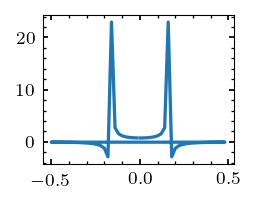

In [9]:
x = np.linspace(0, 50)
y = np.cos(x)
fft = np.fft.fft(y)
freq = np.fft.fftfreq(len(x), d=1)
plt.plot(freq, fft)

When the parameter $d$ of function `numpy.fft.fftfreq(len, d)` is set to 1, the distance between adjacent data point in $x$, the peak wavenumber is the same as expected. Thus, if we put the actual distance in certain unit between two adjacent points as $d$, say 8.33 um in this experiment, the resultant $k$ field will have unit um$^{-1}$.

**2D fftfreq function**

In [11]:
help(compute_wavenumber_field)

Help on function compute_wavenumber_field in module corrLib:

compute_wavenumber_field(shape, d)
    Compute the wave number field Kx and Ky, and magnitude field k. 
    Note that this function works for even higher dimensional shape.
    
    Args:
    shape -- shape of the velocity field and velocity fft field, tuple
    d -- sample spacing. This is the distance between adjacent samples, for example, velocities in PIV. 
        The resulting frequency space has the unit which is inverse of the unit of d. The preferred unit of d is um.
    
    Returns:
    k -- wavenumber magnitude field
    K -- wavenumber fields in given dimensions
    
    Test:
    shape = (5, 5)
    k, K = compute_wavenumber_field(shape, 0.2)



## 2 Compute energy spectrum

### 2.1 Generate perfect velocity correlation

The velocity correlation function should contain the minimum possible amount of noise, so that we can assume the noise from real space is negligible, and only consider the difference in FFT methods. Here, we use data from 08032020 (number 10, 7, 1, corresponding to volume fractions 1.6%, 3.2% and 6.4%, assuming single bacterium volume is 1 um$^3$). Each data is averaged over frame 3000-3400 to minimize the influence of random noise.

In [82]:
plt.figure(dpi=300)
numList = [10, 7, 1]
labelList = [r'1.6%', r'3.2%', r'6.4%']
vcorr_2d = {}
for num, label in zip(numList, labelList):
    temp = []
    for n in range(3000, 3400, 2):
        pivDir = r'D:\density_fluctuations\08032020\piv_imseq\{0:02d}\{1:04d}-{2:04d}.csv'.format(num, n, n+1)
        X, Y, U, V = read_piv(pivDir)
        CV = spatial_correlation(U, U) + spatial_correlation(V, V) # 2D correlation
        temp.append(CV)
    vcorr_2d[label] = np.stack(temp, axis=0).mean(axis=0)    

<Figure size 471x375 with 0 Axes>

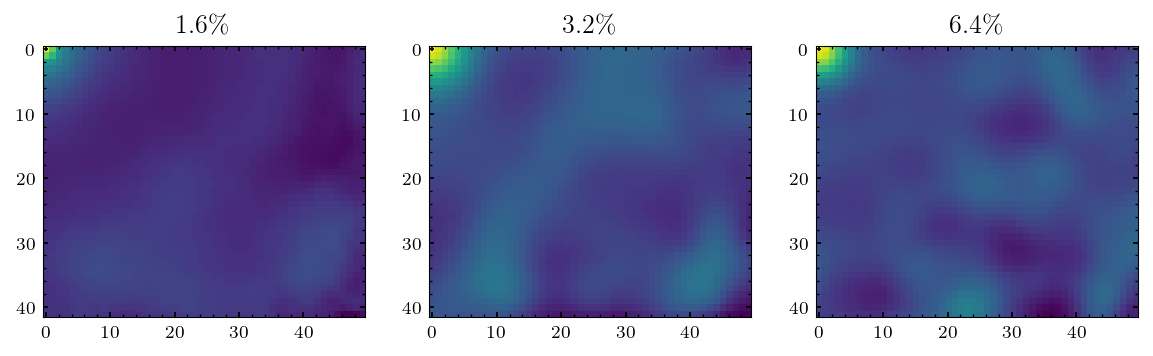

In [83]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))
for num, kw in enumerate(vcorr_2d):
    ax[num].imshow(vcorr_2d[kw])
    ax[num].set_title(kw)

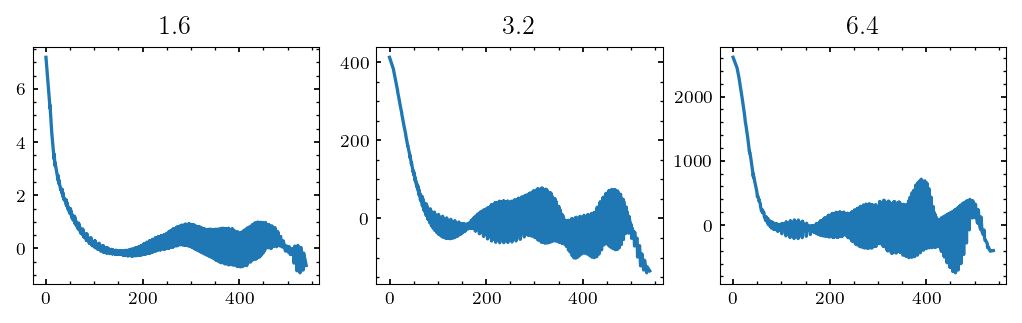

In [172]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 2))
for num, kw in enumerate(vcorr_2d):
    corr = vcorr_2d[kw]
    x = np.linspace(0, corr.shape[1]*25*0.33, corr.shape[1])
    y = np.linspace(0, corr.shape[0]*25*0.33, corr.shape[0])
    X, Y = np.meshgrid(x, y)
    dc = distance_corr(X, Y, corr)
    ax[num].plot(dc.R, dc.C)
    ax[num].set_title(kw)

In [94]:
# Save the averaged spatial velocity correlation
folder = r'I:\Google Drive\Research projects\DF\data\velocity_correlation'
for kw in vcorr_2d:
    name = kw.replace('\\%', '') + r'%'
    np.save(os.path.join(folder, '{}.npy'.format(name)), vcorr_2d[kw])

In [97]:
# To load vcorr_2d from data
# folder = r'I:\Google Drive\Research projects\DF\data\velocity_correlation'
# files = next(os.walk(folder))[2]
# vcorr_2d = {}
# for f in files:
#     kw = f.replace('.npy', '')
#     vcorr_2d[kw] = np.load(os.path.join(folder, f))

### 2.1 Two methods

We compare two methods:

**FFTreal: real part of standard fft**

Energy spectrum function $E(k)$ is defined as
$$
E(k) = \oint \frac{1}{2} \Phi_{ii}(k)d S(k)
$$

where $\Phi_{ii}(k)$ is the diagonal term of velocity spectrum tensor, defined as

$$
\Phi_{ij}(k) = \iiint\limits_{-\infty}^{\infty} R_{ij}(r)e^{-ik\cdot r} dr
$$

here $r$ is position vector (x, y, z) and $R_{ij}$ is spatial velocity correlation of $u_i$, $u_j$ and $u_k$.

It is not feasible to measure the full 3 dimensional flow simultaneous, so take a step back and measure $R_{11}(x, y)$, and thus $\Phi_{11}(k_x, k_y)$.

One dimensional spectra $E_{ij}(k_1)$ are defined to be twice the one dimensional Fourier transform of $R_{ij}(e_1r_1)$:
$$
E_{ij}(k_1) \equiv \frac{1}{\pi}\int^\infty_{-\infty} R_{ij}(e_1r_1)e^{-ik_1r_1}d r_1
$$

Since the flow in the textbook is measured by hot wire, which is naturally 1D, whereas PIV is naturally 2D, I adapt the equation above to a 2D velocity correlation function version:
$$
E_{11}(k_x, k_y) \equiv \frac{1}{\pi}\int^\infty_{-\infty} R_{11}(x, y)e^{-ik\cdot r}d^2r
$$

**velFT: Yi's method**

$$
E(k_x, k_y) = \langle u_k(k_x, k_y)u^*_k(k_x, k_y)+v_k(k_x, k_y)v_k^*(k_x, k_y)\rangle/2
$$

The angle bracket $\langle\rangle$ denotes an average over consecutive frames.

### 2.2 Compare energy spectra at different concentrations using two methods

#### 2.2.1 FFTreal

In [99]:
# Load data
folder = r'I:\Google Drive\Research projects\DF\data\velocity_correlation'
files = next(os.walk(folder))[2]
vcorr_2d = {}
for f in files:
    kw = f.replace('.npy', '')
    vcorr_2d[kw] = np.load(os.path.join(folder, f))

In [17]:
def energy_spectrum_FFTreal(CV, d=25*0.33):
    """
    Compute energy spectrum using method 2
    
    Args:
    CV -- spatial velocity correlation, a 2D numpy array
    d -- actual distance between adjacent velocity (PIV step)
    
    Returns:
    k -- wavenumber flattened
    E -- energy density flattened
    """
    
    E = 1 / np.pi * np.fft.fft2(CV).real
    k, K = corrLib.compute_wavenumber_field(E.shape, d)

    ind = np.argsort(k.flatten())
    k_plot = k.flatten()[ind]
    E_plot = E.flatten()[ind]
    
    return k_plot, E_plot

In [106]:
kE_FFTreal = {} # save k, E data as dict of two-column np arrays (k, E)
for kw in vcorr_2d:
    k, E = energy_spectrum_FFTreal(vcorr_2d[kw], d=25*0.33)
    kE_FFTreal[kw] = np.stack([k, E], axis=1)

Text(0.5, 1.0, 'FFTreal')

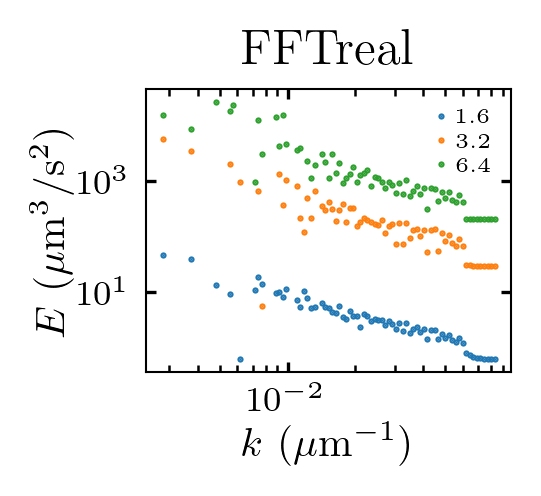

In [171]:
# plot
plt.figure(dpi=300)
for kw in kE_FFTreal:
    x, y = log_bin(kE_FFTreal[kw][:, 0], kE_FFTreal[kw][:, 1])
    plt.plot(x, y, label=kw, ls='', marker='o', markersize=0.5)
plt.legend(fontsize=5)
plt.xlabel('$k$ ($\mu$m$^{-1}$)')
plt.ylabel('$E$ ($\mu$m$^3$/s$^2$)')
plt.loglog()
plt.title('FFTreal')

#### 2.2.2 velFT

In [126]:
numList = [10, 7, 1]
labelList = [r'1.6%', r'3.2%', r'6.4%']
kE_velFT = {} # dict of dataframe with two columns (k, E)
for num, label in zip(numList, labelList):
    for count, n in enumerate(range(3000, 3400, 2)):
        pivDir = r'D:\density_fluctuations\08032020\piv_imseq\{0:02d}\{1:04d}-{2:04d}.csv'.format(num, n, n+1)
        pivData = pd.read_csv(pivDir)
        if count == 0:
            es_temp = energy_spectrum(pivData, 25*0.33)
        else:
            es_temp += energy_spectrum(pivData, 25*0.33)
    kE_velFT[label] = es_temp / (count + 1) / 2

In [131]:
# Save kE_velFT data
folder = r'I:\Google Drive\Research projects\DF\data\velFT'
for kw in kE_velFT:
    kE_velFT[kw].to_csv(os.path.join(folder, '{}.csv'.format(kw)), index=False)

In [132]:
# load kE_velFT data
folder = r'I:\Google Drive\Research projects\DF\data\velFT'
files = next(os.walk(folder))[2]
kE_velFT = {}
for f in files:
    kw = f.replace('.csv', '')
    kE_velFT[kw] = pd.read_csv(os.path.join(folder, f))

Text(0.5, 1.0, 'velFT')

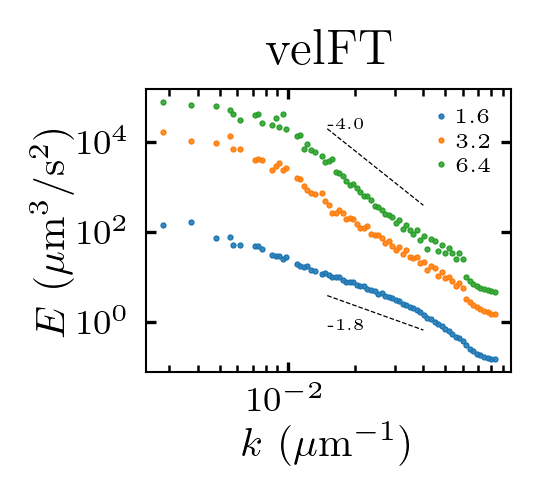

In [170]:
# plot kE_velFT
plt.figure(dpi=300)
for kw in kE_velFT:
    x, y = log_bin(kE_velFT[kw]['k'], kE_velFT[kw]['E'])
    plt.plot(x, y, label=kw, ls='', marker='o', markersize=0.5)
plt.legend(fontsize=5)
plt.xlabel('$k$ ($\mu$m$^{-1}$)')
plt.ylabel('$E$ ($\mu$m$^3$/s$^2$)')
plt.loglog()

# slope guide eye
s = -1.8
x = np.array([0.015, 0.04])
y = x ** s * 2e-3
plt.plot(x, y, ls='--', lw=0.3, color='black')
plt.text(x[0], y[1], '{:.1f}'.format(s), {'fontsize': 4})

s = -4
x = np.array([0.015, 0.04])
y = x ** s * 1e-3
plt.plot(x, y, ls='--', lw=0.3, color='black')
plt.text(x[0], y[0], '{:.1f}'.format(s), {'fontsize': 4})

plt.title('velFT')

### 2.3 Compare the two methods at a fixed concentration

Clearly, the two methods presented above give different energy spectrum result. Below, I apply both methods on each concentration: 1.6%, 3.2% and 6.4%, and compare results.

#### 2.3.1 $\phi=1.6 \%$

In [136]:
kw = r'1.6%'
folder_vcorr = r'I:\Google Drive\Research projects\DF\data\velocity_correlation'
folder_velFT = r'I:\Google Drive\Research projects\DF\data\velFT'
vcorr = np.load(os.path.join(folder_vcorr, '{}.npy'.format(kw)))
velFT = pd.read_csv(os.path.join(folder_velFT, '{}.csv'.format(kw)))

[]

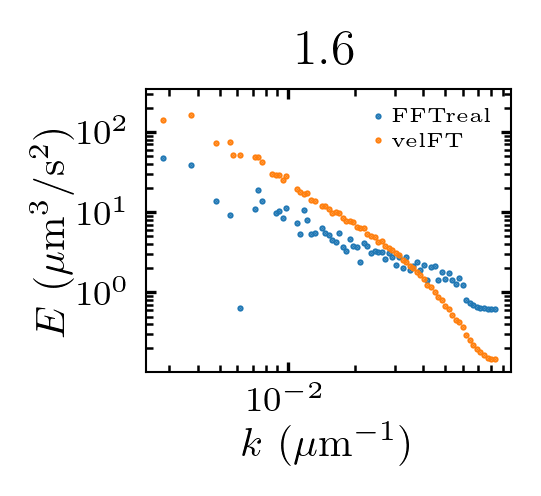

In [145]:
#plot
plt.figure(dpi=300)
k, E = energy_spectrum_FFTreal(vcorr, d=25*0.33)
x, y = log_bin(k, E)
plt.plot(x, y, label='FFTreal', ls='', marker='o', markersize=0.5)
x, y = log_bin(velFT.k, velFT.E)
plt.plot(x, y, label='velFT', ls='', marker='o', markersize=0.5)
plt.title(kw)
plt.legend(fontsize=5)
plt.xlabel('$k$ ($\mu$m$^{-1}$)')
plt.ylabel('$E$ ($\mu$m$^3$/s$^2$)')
plt.loglog()

#### 2.3.1 $\phi=3.2 \%$

In [146]:
kw = r'3.2%'
folder_vcorr = r'I:\Google Drive\Research projects\DF\data\velocity_correlation'
folder_velFT = r'I:\Google Drive\Research projects\DF\data\velFT'
vcorr = np.load(os.path.join(folder_vcorr, '{}.npy'.format(kw)))
velFT = pd.read_csv(os.path.join(folder_velFT, '{}.csv'.format(kw)))

[]

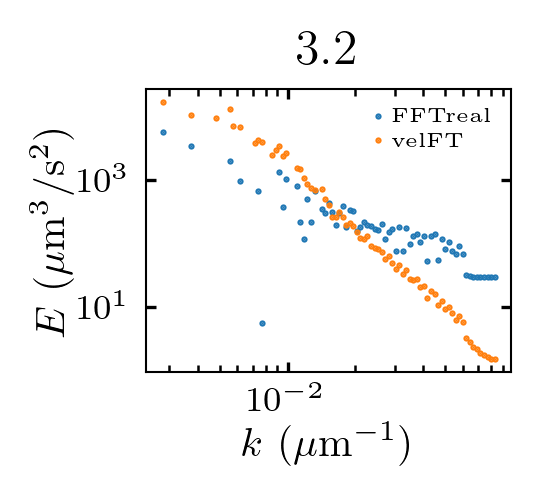

In [147]:
#plot
plt.figure(dpi=300)
k, E = energy_spectrum_FFTreal(vcorr, d=25*0.33)
x, y = log_bin(k, E)
plt.plot(x, y, label='FFTreal', ls='', marker='o', markersize=0.5)
x, y = log_bin(velFT.k, velFT.E)
plt.plot(x, y, label='velFT', ls='', marker='o', markersize=0.5)
plt.title(kw)
plt.legend(fontsize=5)
plt.xlabel('$k$ ($\mu$m$^{-1}$)')
plt.ylabel('$E$ ($\mu$m$^3$/s$^2$)')
plt.loglog()

#### 2.3.1 $\phi=6.4 \%$

In [15]:
kw = r'6.4%'
folder_vcorr = r'E:\Google Drive\Research projects\DF\data\velocity_correlation'
folder_velFT = r'E:\Google Drive\Research projects\DF\data\velFT'
vcorr = np.load(os.path.join(folder_vcorr, '{}.npy'.format(kw)))
velFT = pd.read_csv(os.path.join(folder_velFT, '{}.csv'.format(kw)))

E:\Github\Python\Correlation\src\corr_utils.py:1230: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])
E:\Github\Python\Correlation\src\corr_utils.py:1230: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])


[]

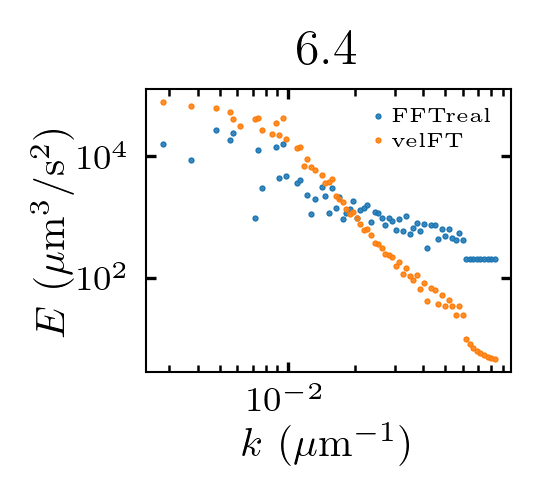

In [18]:
#plot
plt.figure(dpi=300)
k, E = energy_spectrum_FFTreal(vcorr, d=25*0.33)
x, y = log_bin(k, E)
plt.plot(x, y, label='FFTreal', ls='', marker='o', markersize=0.5)
x, y = log_bin(velFT.k, velFT.E)
plt.plot(x, y, label='velFT', ls='', marker='o', markersize=0.5)
plt.title(kw)
plt.legend(fontsize=5)
plt.xlabel('$k$ ($\mu$m$^{-1}$)')
plt.ylabel('$E$ ($\mu$m$^3$/s$^2$)')
plt.loglog()

## 3 Fit spectrum curve with formula
$$
E_k = 4\pi n \kappa^2 \left[ \frac{1}{3} + \frac{\cos(kl)}{(kl)^2} - \frac{\sin(kl)}{(kl)^3} \right] \frac{\epsilon^4k^2}{l^2} K_2^2(k\epsilon)
$$
- $\kappa$ is stresslet strength, $\epsilon$ is a factor describing the distance over which the regularisation acts and $K_2$ is the modified Bessel function of the second kind, $l$ is the dipolar length
- $\kappa \approx 11.2$ for _E. coli_, it is dimensionless
- I don't have an estimate for $\epsilon$, so try to range it from small to large (compare to 1)
- $K_2$ can be computed using `scipy.special.kn`, use `K2 = kn(2, x)`, [reference](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.kn.html#scipy.special.kn)
- $l \approx 1.9$ um 
- Estimate the length scale in the simulation:
    - $\phi = (4\pi/3)a^3n$, $a = 0.3$
    - typical _E. coli_ is $1\times1\times1$ um$^3$, so 1 um corresponds to 0.3 in the simulation unit
    - the wavenumber unit is thus 1/(3.33um) = 0.3 um$^{-1}$

**construct the function to be fitted**

In [154]:
def E_k(k, n, ep = 1):
    """
    Energy spectrum in active turbulence | Boltzmann Lattice simulation | reference Bardfalvy 2019
    https://pubs.rsc.org/en/content/articlelanding/2019/sm/c9sm00774a#!divAbstract
    
    k -- wavenumber (um^-1)
    ep -- a factor describing the distance over which the regularisation acts
    """
    
    kappa = 11.2
    K_2 = kn(2, k*ep)
    l = 1.9
    
    
    Ek = 4 * np.pi * n * kappa**2 * (1/3 + np.cos(k*l)/(k*l)**2 - np.sin(k*l)/(k*l)**3) * ep**4 * k**2 / l**2 * K_2
    
    return Ek

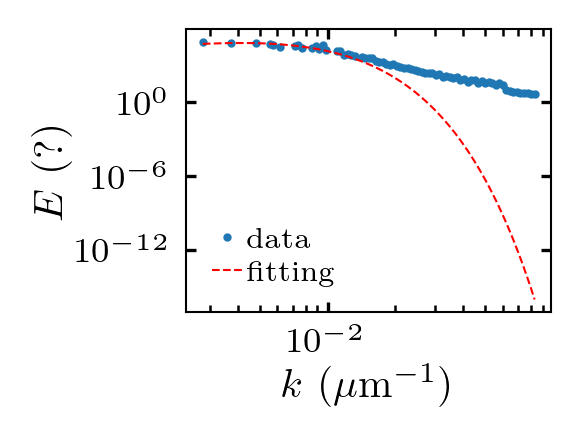

In [160]:
xx = x[(np.isnan(y)==False)&(x!=0)]
yy = y[(np.isnan(y)==False)&(x!=0)]
popt, pcov = curve_fit(E_k, xx, yy)
plt.figure(dpi=300)
plt.plot(x, y, ls='', marker='o', markersize=1, label='data')
n = 0.05
ep = 1
# xtest = np.logspace(-1.5, 0.5)
# plt.plot(xtest, E_k(xtest, n))
plt.plot(xx, E_k(xx, *popt), ls='--', color='red', lw=0.5, label='fitting')
plt.loglog()
plt.legend(fontsize=5)
plt.xlabel('$k$ ($\mu$m$^{-1}$)')
plt.ylabel('$E$ (?)')
plt.legend(loc='lower left', fontsize=7)

## 4 How to bin energy spectrum data from 2D to 1D?

$E(k)$, according to the definition, should have the property $\int E(k)dk = E_{total}$. Similarly, $E(k_x, k_y)$ should satisfy $\iint $E(k_x, k_y)dk_xdk_y = E_{total}$.

When converting $E(k_x, k_y)$ to scalar variable $E(k)$, all the spots in the shell $\sqrt{k_x^2+k_y^2}-k \le dr$

(-0.5, 9.5, 9.5, -0.5)

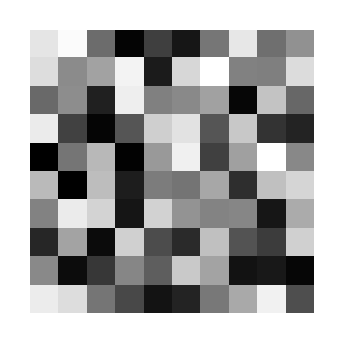

In [162]:
plt.figure(dpi=300)
a = np.random.rand(10, 10)
plt.imshow(a, cmap='gray')
plt.axis('off')